<a href="https://colab.research.google.com/github/kogby/DA_KKTV/blob/neo_branch/0528model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 套件安裝

In [12]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab/資料分析期末') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['data',
 'models',
 '0519KKTV.ipynb',
 '0521KKTV (light).ipynb',
 'preprocessed_output',
 'large0520.ipynb',
 'largetestPre0528.ipynb',
 '過往東東',
 'submit.csv',
 '0528model.ipynb']

In [13]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [15]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [16]:
def show_loss(train_loss, valid_loss):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(train_loss, color='blue', linewidth=2)
    axes[0].set_title('Training Loss', fontsize=16)
    axes[0].set_xlabel('iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot validation loss
    axes[1].plot(valid_loss, color='red', linewidth=2)
    axes[1].set_title('Validation Loss', fontsize=16)
    axes[1].set_xlabel('iteration', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## 資料長相（train有source, target / test只有source

In [17]:
#('./preprocessed_output/train_duration_target.npy')
#('./preprocessed_output/duration_data_scaled.npy')
#('./preprocessed_output/test_duration_data_scaled.npy')

In [18]:
duration_mtx = np.load('./preprocessed_output/train_duration_target.npy')
duration_mtx[3]

array([0.72346628, 0.72757658, 0.        , 0.        , 0.        ,
       0.96137999, 0.        , 0.        , 0.73008688, 0.73424334,
       0.        , 0.        , 0.48737869, 0.78076653, 0.        ,
       0.        , 0.74081479, 0.66950438, 0.        , 0.        ,
       0.        , 0.78084127, 0.        , 0.        , 0.        ,
       0.67581326, 0.        , 0.        ])

## 加載資料

In [22]:
class TrainDataset(Dataset):
    # data loading
    def __init__(self, file_name_X, file_name_Y):
        #X = pd.read_csv(file_name_X).drop(columns=['user_id']).to_numpy()
        #X = X.reshape(X.shape[0], -1, 28) #變成每七天一個vector feature input_size=28, seq_len=37
        X = np.load(file_name_X)
        X = X.reshape(X.shape[0], -1, 4) #變成每七天一個vector feature input_size=28, seq_len=37
        Y = np.load(file_name_Y)
        self.x = torch.from_numpy(X).to(torch.float32)
        self.y = torch.from_numpy(Y).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = 4

    # working for indexing
    def __getitem__(self, index):
        return self.x[index], self.y[index] #符合lstm的輸入 (batch_first)
    def __len__(self):
        return self.n_samples

class TestDataset(Dataset):
    # data loading
    def __init__(self, file_name_X):
        X = np.load(file_name_X)
        X = X.reshape(X.shape[0], -1, 4) 
        self.x = torch.from_numpy(X).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = 4

    # working for indexing
    def __getitem__(self, index):
        return self.x[index] #符合lstm的輸入 seqlen再改
    def __len__(self):
        return self.n_samples

In [23]:
dataset_train = TrainDataset('./preprocessed_output/duration_data_scaled.npy', './preprocessed_output/train_duration_target.npy')
dataset_test = TestDataset('./preprocessed_output/test_duration_data_scaled.npy')

batch_size = 16 #符合test loader的因數
valid_ratio = 0.2
valid_set_size = int(valid_ratio * len(dataset_train)) #驗證集大小
train_set_size = len(dataset_train) - valid_set_size #訓練集大小
dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train, [train_set_size, valid_set_size])

train_loader = DataLoader(dataset_train ,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, drop_last=False)

In [24]:
for _, (data, labels) in enumerate(train_loader):
  print(data.shape, labels.shape) #train:1036 columns, test:28 columns 
  break; ## seqlen根据数据特征数量调整，1036/28 = 37

torch.Size([16, 259, 4]) torch.Size([16, 28])


## 模型
https://blog.csdn.net/qq_40728805/article/details/103959254?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&utm_relevant_index=4
对于单层单向的LSTM， 其h_n最后一层输出h_n[-1,:,:]，和output最后一个时步的输出output[-1,:,:]相等。如果是分类任务的话，就可以把output[-1, :, :]或者output送到一个分类器分类。

比如：在做文字识别中，先对文本行图片提取feature，如shape为(B, 512, 1, 16)其中512是channel 维度，1是height，16是width，tensor处理为(B, 16, 512)或(16, B, 512)因为lstm要求输入是3D的，CNN的feature是4D的。

那这样，512就是input_size, 16就是seq_len
<br>
輸入LSTM:(batchsize,seqlen,inputsize) when batch_first=True 


https://discuss.pytorch.org/t/understanding-lstm-input/31110/5 LSTM input

In [32]:
class SimpleLSTM(nn.Module):

    def __init__(self):
        super(SimpleLSTM, self).__init__()

        self.input_size = 4 #一週七天*4 slot
        self.seq_len = int(1036/self.input_size)

        self.n_layers = 2 # LSTM的层数
        self.hidden_dim = 256 # 隐状态的维度，即LSTM输出的隐状态的维度
        self.output_size = 28 #輸出為每筆資料有28個欄位
        drop_prob=0.3 # dropout
        
        self.lstm = nn.LSTM(input_size = self.input_size, # 输入的维度
                            hidden_size = self.hidden_dim, # LSTM输出的hidden_state的维度
                            num_layers = self.n_layers, # LSTM的层数
                            dropout=drop_prob, 
                            batch_first=True # 第一个维度是否是batch_size
                           )
        self.fc_1 = nn.Linear(self.hidden_dim*self.seq_len, 128) #fc1
        self.fc_2 =  nn.Linear(128, self.output_size) #fc2
        self.sigmoid = nn.Sigmoid() # 线性层输出后，还需要过一下sigmoid
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        x: 本次的输入，其size为(batch_size, 37, 28)，37 為sequence len, 28為input_dim
        其中h和c的size都为(n_layers, batch_size, hidden_dim), 即(2, 64, 128)
        """
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) #非雙向
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        out, (ht,ct) = self.lstm(x, (h_0,c_0)) #out 為 (batch_size64, seqlen37, hidden_dim128) 
        #print(f'original shape:{out.shape}')
        #print(out)
        out = out.reshape(batch_size, -1)
        #print(f'modified shape:{out.shape}')
        #print(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out) 
        out = self.sigmoid(out)
        #print(out.shape) #batchsize, 28
        return out

## 訓練過程

In [33]:
def train(train_loader, valid_loader, model, model_name, epochs_num = 5):

  #criterion = nn.CrossEntropyLoss()
  criterion = nn.BCELoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, eps=1e-08, weight_decay=0.0001)
  loss_train = []
  loss_valid = []
  for epoch in range(epochs_num):
    model.train() # Set model to train mode
    train_pbar = tqdm(train_loader, position=0, leave=True)
    for datas, labels in train_pbar: #each batch 
      datas, labels = datas.to(device), labels.to(device) 
      optimizer.zero_grad() 
      outputs = model(datas) 
      loss = criterion(outputs, labels)  
      loss.backward() #反向傳播
      optimizer.step()
      loss_train.append(loss.detach().cpu().numpy())  
    #-----------------------validation----------------------#
    model.eval()
    with torch.no_grad(): #代表這裡面不會有backpropagation梯度，不會有調整優化
      for datas, labels in valid_loader:
        datas, labels = datas.to(device), labels.to(device) 
        outputs = model(datas) 
        loss = criterion(outputs, labels)  
        loss_valid.append(loss.detach().cpu().numpy())
  show_loss(loss_train, loss_valid)

## 真正訓練


  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

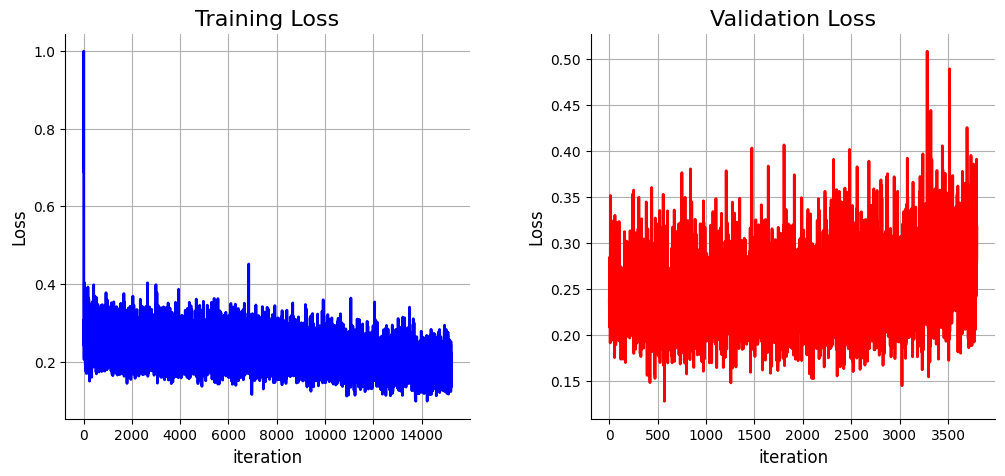

In [34]:
num_epoch = 10
model = SimpleLSTM().to(device)
train(train_loader, valid_loader, model, "SimpleLSTM", epochs_num = num_epoch)

## 產生輸出

In [35]:
model.eval()
output_list = []
with torch.no_grad():
  for datas in test_loader:
    datas = datas.to(device) 
    output_list.append(model(datas).cpu())

In [36]:
flatten_data = np.concatenate(output_list, axis=0)
showans = pd.DataFrame(flatten_data)
showans

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.155968,0.055352,0.000024,0.009233,0.041378,0.040859,6.713594e-07,0.197891,0.010923,0.056021,...,0.000024,0.179840,0.015033,0.008861,0.000018,0.111871,0.010511,0.008052,0.000008,0.009070
1,0.050887,0.299354,0.007448,0.001485,0.064953,0.284329,9.200226e-04,0.000611,0.009950,0.233667,...,0.000807,0.000505,0.008121,0.196596,0.001402,0.000354,0.008402,0.176626,0.007277,0.000804
2,0.233755,0.064787,0.004200,0.008768,0.040932,0.114047,4.536338e-03,0.075299,0.343333,0.272344,...,0.036970,0.093408,0.179383,0.203034,0.011605,0.020034,0.027028,0.064861,0.007674,0.025751
3,0.001431,0.001545,0.000448,0.000487,0.004093,0.004351,2.748149e-03,0.000693,0.022863,0.008679,...,0.001125,0.000831,0.014360,0.011529,0.000182,0.000113,0.004590,0.004462,0.000658,0.000445
4,0.018899,0.032329,0.028279,0.000177,0.077553,0.069985,3.007071e-02,0.000716,0.275946,0.112940,...,0.021685,0.000496,0.202875,0.059446,0.032452,0.000251,0.150469,0.047207,0.004767,0.000155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.068288,0.058289,0.028735,0.052610,0.137634,0.093465,5.842536e-03,0.007772,0.015633,0.058611,...,0.001400,0.004500,0.018919,0.022480,0.002564,0.004028,0.029298,0.039666,0.013022,0.010436
7612,0.615483,0.522784,0.026901,0.045661,0.382696,0.412754,6.262453e-03,0.046674,0.451430,0.429421,...,0.006959,0.026518,0.345709,0.290730,0.003832,0.025605,0.306439,0.269416,0.006325,0.022476
7613,0.707871,0.777397,0.070204,0.068152,0.492146,0.556305,8.029202e-03,0.042356,0.413038,0.501957,...,0.003373,0.009682,0.378114,0.350597,0.001612,0.008331,0.302926,0.222101,0.003018,0.014204
7614,0.045939,0.077430,0.024161,0.013303,0.068712,0.107350,1.741758e-02,0.010066,0.047634,0.082151,...,0.011675,0.006856,0.050237,0.095675,0.014321,0.006167,0.043941,0.074856,0.019385,0.006715


In [37]:
sample = pd.read_csv("./data/sample.csv")
answer = sample
for i in range(1,29):
    answer.iloc[:,i] = showans.iloc[:, i-1]
display(answer)

<ipython-input-37-20a01fd229e5>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  answer.iloc[:,i] = showans.iloc[:, i-1]


,user_id,time_slot_0,time_slot_1,time_slot_2,time_slot_3,time_slot_4,time_slot_5,time_slot_6,time_slot_7,time_slot_8,...,time_slot_18,time_slot_19,time_slot_20,time_slot_21,time_slot_22,time_slot_23,time_slot_24,time_slot_25,time_slot_26,time_slot_27
0,30460,0.155968,0.055352,0.000024,0.009233,0.041378,0.040859,6.713594e-07,0.197891,0.010923,...,0.000024,0.179840,0.015033,0.008861,0.000018,0.111871,0.010511,0.008052,0.000008,0.009070
1,30461,0.050887,0.299354,0.007448,0.001485,0.064953,0.284329,9.200226e-04,0.000611,0.009950,...,0.000807,0.000505,0.008121,0.196596,0.001402,0.000354,0.008402,0.176626,0.007277,0.000804
2,30462,0.233755,0.064787,0.004200,0.008768,0.040932,0.114047,4.536338e-03,0.075299,0.343333,...,0.036970,0.093408,0.179383,0.203034,0.011605,0.020034,0.027028,0.064861,0.007674,0.025751
3,30463,0.001431,0.001545,0.000448,0.000487,0.004093,0.004351,2.748149e-03,0.000693,0.022863,...,0.001125,0.000831,0.014360,0.011529,0.000182,0.000113,0.004590,0.004462,0.000658,0.000445
4,30464,0.018899,0.032329,0.028279,0.000177,0.077553,0.069985,3.007071e-02,0.000716,0.275946,...,0.021685,0.000496,0.202875,0.059446,0.032452,0.000251,0.150469,0.047207,0.004767,0.000155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,38071,0.068288,0.058289,0.028735,0.052610,0.137634,0.093465,5.842536e-03,0.007772,0.015633,...,0.001400,0.004500,0.018919,0.022480,0.002564,0.004028,0.029298,0.039666,0.013022,0.010436
7612,38072,0.615483,0.522784,0.026901,0.045661,0.382696,0.412754,6.262453e-03,0.046674,0.451430,...,0.006959,0.026518,0.345709,0.290730,0.003832,0.025605,0.306439,0.269416,0.006325,0.022476
7613,38073,0.707871,0.777397,0.070204,0.068152,0.492146,0.556305,8.029202e-03,0.042356,0.413038,...,0.003373,0.009682,0.378114,0.350597,0.001612,0.008331,0.302926,0.222101,0.003018,0.014204
7614,38074,0.045939,0.077430,0.024161,0.013303,0.068712,0.107350,1.741758e-02,0.010066,0.047634,...,0.011675,0.006856,0.050237,0.095675,0.014321,0.006167,0.043941,0.074856,0.019385,0.006715


In [38]:
answer.to_csv("submit.csv", index=False)